**Tweettalyze** is an application that, given in input one or more Tweets, returns their Sentiment Analysis, as well as a series of graphs and useful information about them.

This analysis offers a set of data that have multiple fields of interest. 
For example, to provide information about the perception of the trendiest topics, about prominent personalities (stars, politicians, etc.), or to help define the Brand Awareness of a given brand.


*R. Pane, R.Mele, A. Moggio.*

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Import Libreries

In [0]:
#pip install nltk
#pip install matplotlib
#pip install wordcloud
#pip install PIL        
#pip install colorama
#pip install termcolor

In [0]:
from colorama import Fore, Style
from termcolor import colored
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import twitter_samples, stopwords
from nltk import FreqDist, classify, NaiveBayesClassifier
from nltk.chat.util import Chat, reflections  # Chatbot
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

import numpy
import nltk
#nltk.download('all')
import re, string, random
import matplotlib.pyplot as plt

Pre-Processing Text (Removing 'Stop Words', Lowering, Punctuation, Stemming , Lemmatization)

In [0]:
def pre_process(tweet_tokens, stop_words = ()):    

    clean_tok = []
    
    # Pos-Tag 
    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)      
        # sub replace the special characters with "" <-- a blank space
        
        # We generate more generic Tags 
        if tag.startswith("NN"):
            pos = 'n'                 # n = Nouns
        elif tag.startswith('VB'):
            pos = 'v'                 # v = Verbs
        else:
            pos = 'a'                 # a = Adjectives and Adverbs

        # Lemmatization
        lemmer = WordNetLemmatizer()           # WordNet is a lexical database for the English Language
        token = lemmer.lemmatize(token, pos)   # Lemmatize
        
        # we remove the punctuation and lower the characters of the words
        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            clean_tok.append(token.lower())
    return clean_tok


This is a generator function that takes a list of tweets as an argument to provide a list of words in all of the tweet tokens joined

In [0]:
def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token         # return a generator

Convert the tweets from a list of cleaned tokens to dictionaries with keys as the tokens and True as values

In [0]:
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)


This is the Core of our Sentiment Analysis with Machine Learning


[(':)', 3691), (':-)', 701), (':d', 658), ('thanks', 388), ('follow', 357), ('love', 333), ('...', 290), ('good', 283), ('get', 263), ('thank', 253)]

[(':(', 4585), (':-(', 501), ("i'm", 343), ('...', 332), ('get', 325), ('miss', 291), ('go', 275), ('please', 275), ('want', 246), ('like', 218)]


Accuracy is: 0.9964

Most Informative Features
                      :( = True           Negati : Positi =   2236.2 : 1.0
                      :) = True           Positi : Negati =   1062.6 : 1.0
                follower = True           Positi : Negati =     38.1 : 1.0
                 welcome = True           Positi : Negati =     21.3 : 1.0
                     bam = True           Positi : Negati =     20.5 : 1.0
                     sad = True           Negati : Positi =     19.2 : 1.0
                      aw = True           Negati : Positi =     16.7 : 1.0
                     ugh = True           Negati : Positi =     14.7 : 1.0
              appreciate = True           Positi : Ne

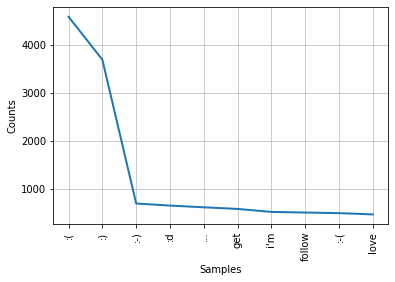

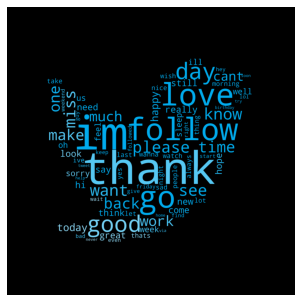

In [46]:
if __name__ == "__main__":
    
    # We import three datasets containing various tweets to train and test from NLTK
    positive_tweets = twitter_samples.strings('positive_tweets.json')  # 5k positive tweets
    negative_tweets = twitter_samples.strings('negative_tweets.json')  # 5k negative tweets
    text = twitter_samples.strings('tweets.20150430-223406.json')      # 20k tweets with no sentiments
    tweet_tokens = twitter_samples.tokenized('positive_tweets.json')[0]

    # Remove 'Stop Words'
    stop_words = stopwords.words('english')
    # Tokenized Tweets
    positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
    negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

    # Create two lists, one with the pre-processed Positive Tweets and the other with the negative ones
    positive_cleaned_tokens_list = []
    negative_cleaned_tokens_list = []

    for tokens in positive_tweet_tokens:
        positive_cleaned_tokens_list.append(pre_process(tokens, stop_words))

    for tokens in negative_tweet_tokens:
        negative_cleaned_tokens_list.append(pre_process(tokens, stop_words))

    # This is a generator function that takes a list of tweets as an argument to provide a list of words in all of the tweet tokens joined
    all_pos_words = get_all_words(positive_cleaned_tokens_list)
    all_neg_words = get_all_words(negative_cleaned_tokens_list)

    # We calculate the frequency with which Positive words appear, printing the 10 most common ones
    pfreq = FreqDist(all_pos_words)
    print()
    print(colored(pfreq.most_common(10),'green'))     # Positive
    print()

    # We calculate the frequency with which Negative words appear, printing the 10 most common ones
    nfreq = FreqDist(all_neg_words)
    print(colored(nfreq.most_common(10),'red'))     # Negative
    print()

    freq = nfreq + pfreq 

    # Converting Tokens to Dictionary
    positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)  
    negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

    # We create the Model for the training and test. For each phase we build a dataset formed by positive and negative shuffled data 
    positive_data = [(tweet_dict, "Positive  :)")           # This code attaches a Positive label to each tweet
                         for tweet_dict in positive_tokens_for_model]

    negative_data = [(tweet_dict, "Negative :(")            # This code attaches a Negative label to each tweet
                         for tweet_dict in negative_tokens_for_model]

    dataset = positive_data + negative_data
    random.shuffle(dataset)       # it's to avoid Bias

    # The purpose of the first part is to build the model; the next part tests the performance of the model.
    train_data = dataset[:7500]     
    test_data = dataset[7500:]

    # For the Classification we used a NaiveBayes Classifier
    classifier = NaiveBayesClassifier.train(train_data)
    # Naive Bayes classifiers are paramaterized by two probability distributions:
    #  - P(label) gives the probability that an input will receive each label, given no information about the input's features.
    #  - P(fname=fval|label) gives the probability that a given feature (fname) will receive a given value (fval), given that the label (label).

    # If the classifier encounters an input with a feature that has never been seen with any label, then rather than assigning a
    # probability of 0 to all labels, it will ignore that feature.

    
    print()
    print("Accuracy is:", colored(classify.accuracy(classifier, test_data), 'red'))
    print()
    print(classifier.show_most_informative_features(10))
    print()
    freq.plot(10,cumulative=False)
    plt.show()
    
    # We tested the Model on some famous books too
    # do = open("Dorian.txt","r")     # Picture of Dorian Gray
    # ad = open("advs.txt","r")       # Collection  of Sherlock Holmes
    # al = open("alice.txt","r")      # Alice in Wonderland
    # sh = open("shake.txt","r")      # All's Well That Ends Well
    # print(colored('hello', 'red'), colored('world', 'green'))
    # print(f'This is {Fore.GREEN} color {Style.RESET_ALL}!')

    # Print a WordCloud of the 100 most common words with the shape of the Twitter Logo
    freq100 = freq.most_common(100)
    strfreq100 = str(freq100)
    strfreq100 = re.sub("'",'', strfreq100)

    char_mask = numpy.array(Image.open("/content/white.jpg"))    
    image_colors = ImageColorGenerator(char_mask)
    wc = WordCloud(width = 800, height = 800,background_color="black", max_words=200, mask=char_mask, random_state=1).generate(strfreq100) 
    # to recolour words in the image
    rec = wc.recolor(color_func=image_colors)
    plt.imshow(rec)
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show()

The Chatbot code

In [49]:
exit_codes=['bye', 'exit', 'see you' ,'ciao']
flag=True
res_lis = []

print("Tweettalyze analyzes your Tweets and makes a Sentimental Analysis of them")
print()

while(flag==True):
    custom_tweet=input("Insert the tweet that you want to analyze:  >>  ")
    print()
    if  custom_tweet.lower() not in exit_codes:
        # We process the tweet. Then we print it(processed) with the result of the classifier(i.e. our Sentment Analysis)
        custom_tokens = pre_process(word_tokenize(custom_tweet))              # (Removing 'Stop Words', Lowering, Punctuation, Stemming , Lemmatization)
        print(custom_tokens,'\n','\n', classifier.classify(dict([token, True] for token in custom_tokens))) 
        res_lis.append(classifier.classify(dict([token, True] for token in custom_tokens)))   # it saves the output
        # It asks if the user wants to analyze an other Tweet
        print("\n\n Do you want to analyze a new tweet? (yes o no)")
        print()
        custom_tweet=input()
        print()
        
        # This is the algorithm that manages the exit point
    if custom_tweet.lower() =="no" or custom_tweet.lower() in exit_codes:
        print("Hi, it was a pleasure chatting with you!")
        flag=False

Tweettalyze analyzes your Tweets and makes a Sentimental Analysis of them

Insert the tweet that you want to analyze:  >>  I #hate @You!!! ò_ò

['i', 'hate', 'you', 'ò_ò'] 
 
 Negative :(


 Do you want to analyze a new tweet? (yes o no)

yes

Insert the tweet that you want to analyze:  >>  I like to listen to music!

['i', 'like', 'to', 'listen', 'to', 'music'] 
 
 Positive  :)


 Do you want to analyze a new tweet? (yes o no)

yes

Insert the tweet that you want to analyze:  >>  we need a #change in the way we look at things

['we', 'need', 'a', 'change', 'in', 'the', 'way', 'we', 'look', 'at', 'thing'] 
 
 Positive  :)


 Do you want to analyze a new tweet? (yes o no)

yes

Insert the tweet that you want to analyze:  >>  Those who find beautiful meanings In  beautiful things are the cultivated. For  these there Is hope.

['those', 'who', 'find', 'beautiful', 'meaning', 'in', 'beautiful', 'thing', 'be', 'the', 'cultivated', 'for', 'these', 'there', 'is', 'hope'] 
 
 Positive  :)


 D

Showing what is in 'res_lis'

In [50]:
res_lis

['Negative :(', 'Positive  :)', 'Positive  :)', 'Positive  :)']

Print a Plot of the occurrences of positive and negative results

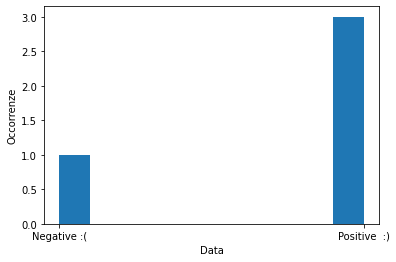

In [51]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
x = res_lis 

plt.hist(x, density=False)  # `density=False` would make counts
plt.ylabel('Occorrenze')
plt.xlabel('Data');

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')